In [36]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
# %pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.4.0/ru_core_news_sm-3.4.0-py3-none-any.whl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

In [2]:
data = pd.read_csv("./data/data.csv")[:5000]
data = data.rename(columns={"Rating": "target", "Review": "review"})
data.target = data.target.map(lambda x: 1 if x >= 4 else 0)
data.head()

,review,target
0,3D Touch просто восхитительная вещь! Заряд дер...,1
1,"Отключается при температуре близкой к нулю, не...",1
2,"В Apple окончательно решили не заморачиваться,...",0
3,Постарался наиболее ёмко и коротко описать все...,1
4,Достойный телефон. Пользоваться одно удовольст...,1


## Предобработка данных

In [3]:
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=True, random_state=42)
train_data = train_data.reset_index()[['review', 'target']]
test_data = test_data.reset_index()[['review', 'target']]
# train_data = train_data[:1000] # Если не хватает ресурсов
# test_data = test_data[:100] # Если не хватает ресурсов
print(train_data.shape)
print(test_data.shape)
train_data.head()

(4500, 2)
(500, 2)


,review,target
0,"Это не смартфон, это просто трубка с сенсором,...",0
1,"Подарили на Новый год был очень сильно рад,в ц...",1
2,Отличный смарт .,1
3,Купил этот телефон из за многообещающих характ...,0
4,"пользуюсь уже 8 месяц, вообщем то даволен. За ...",1


In [4]:
nlp = spacy.load("ru_core_news_sm")
def preprocess_text(text):
    doc = nlp(str(text))
    for token in doc:
        if token.is_stop or token.is_punct or token.like_num or token.like_url \
        or token.like_email or token.is_digit or len(token) <= 1 or token.is_space \
        or not re.match(r'^[a-zA-Zа-яА-Я]+$', str(token)):
            continue
        yield token.lemma_


X_train = train_data.review.map(lambda x: " ".join(preprocess_text(x)))
y_train = train_data.target
X_test = test_data.review.map(lambda x: " ".join(preprocess_text(x)))
y_test = test_data.target

In [5]:
X_train.head()

0    смартфон трубка сенсор приложение живой симбиа...
1    подарить новый год сильно рад целое телефон до...
2                                       отличный смарт
3    купить телефон многообещающих характеристика к...
4    пользоваться месяц вообщем даволен деньга хоро...
Name: review, dtype: object

## Графики

Text(0, 0.5, 'Количество записей')

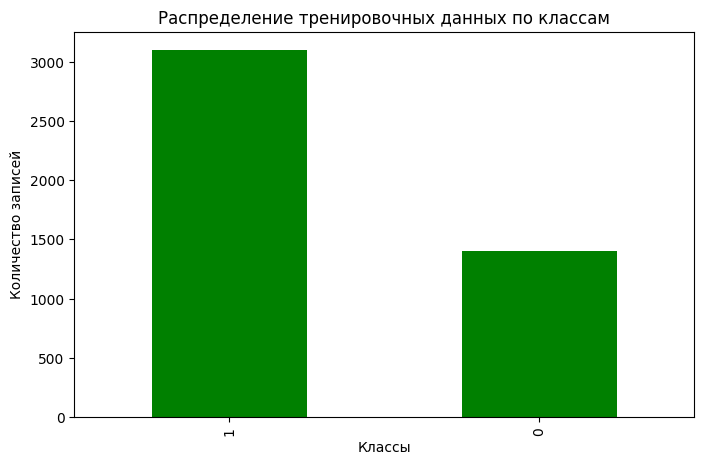

In [6]:
plt.figure(figsize=(8,5))
y_train.value_counts().plot(kind='bar',color='green')
plt.title('Распределение тренировочных данных по классам')
plt.xlabel('Классы')
plt.ylabel('Количество записей')

Text(0, 0.5, 'Количество записей')

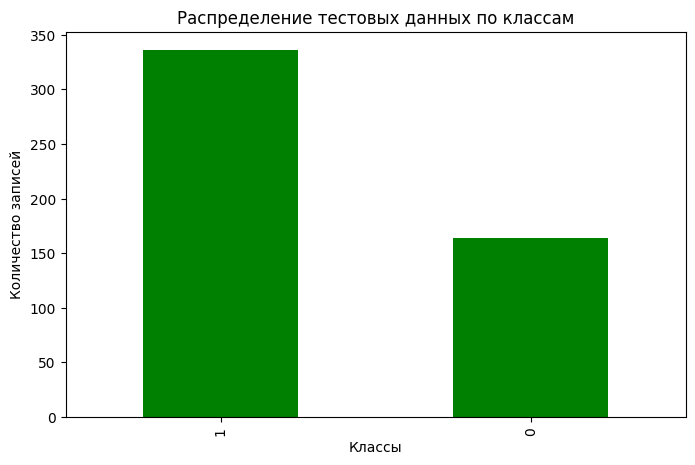

In [7]:
plt.figure(figsize=(8,5))
y_test.value_counts().plot(kind='bar',color='green')
plt.title('Распределение тестовых данных по классам')
plt.xlabel('Классы')
plt.ylabel('Количество записей')

Text(0, 0.5, 'Количество твитов')

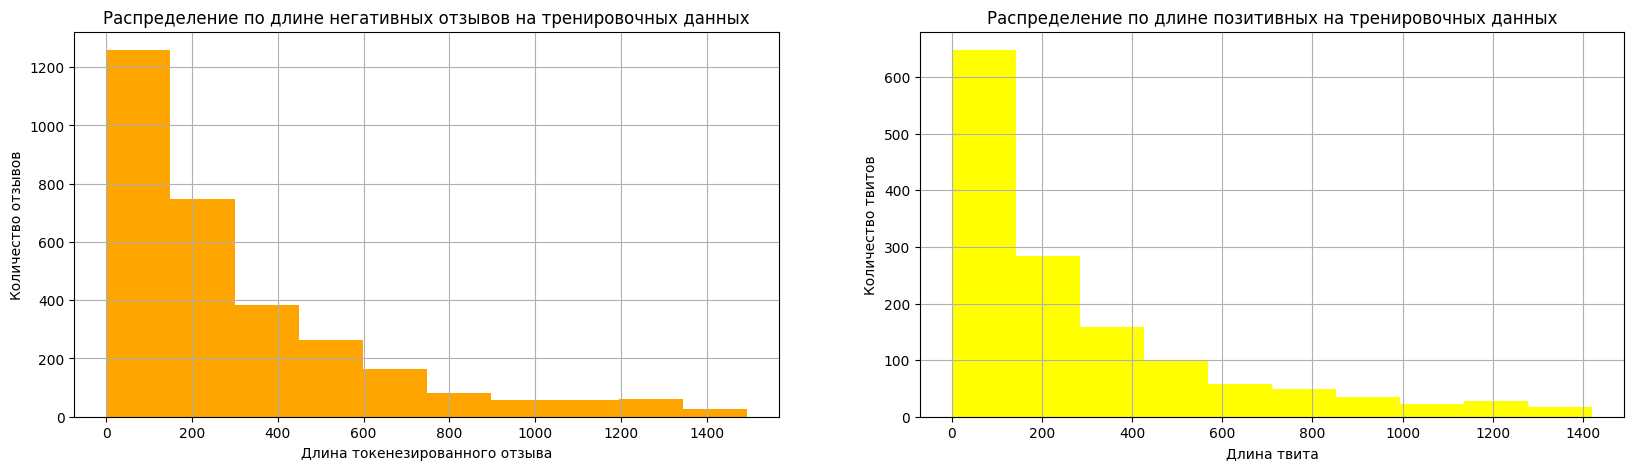

In [8]:
len_negatives = X_train[y_train == 1].str.len()
len_positives = X_train[y_train == 0].str.len()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(len_negatives,color='orange')
plt.grid()
plt.title('Распределение по длине негативных отзывов на тренировочных данных')
plt.xlabel('Длина токенезированного отзыва')
plt.ylabel('Количество отзывов')
plt.subplot(1,2,2)
plt.hist(len_positives,color='yellow',)
plt.grid()
plt.title('Распределение по длине позитивных на тренировочных данных')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')

Text(0, 0.5, 'Количество твитов')

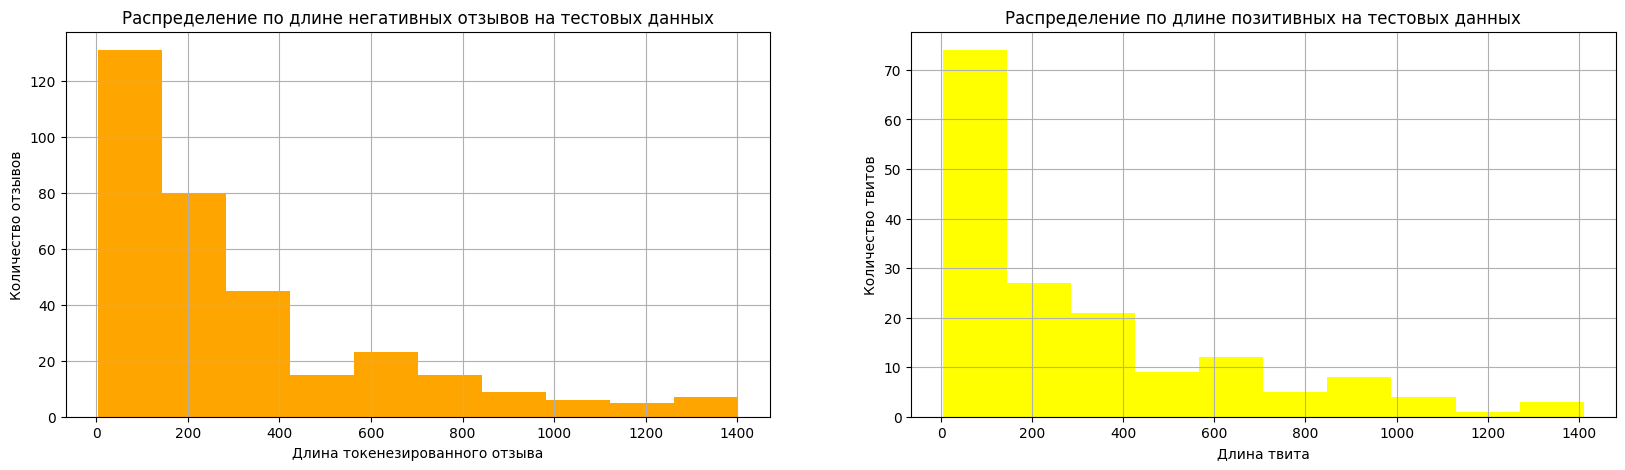

In [9]:
len_negatives = X_test[y_test == 1].str.len()
len_positives = X_test[y_test == 0].str.len()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(len_negatives,color='orange')
plt.grid()
plt.title('Распределение по длине негативных отзывов на тестовых данных')
plt.xlabel('Длина токенезированного отзыва')
plt.ylabel('Количество отзывов')
plt.subplot(1,2,2)
plt.hist(len_positives,color='yellow',)
plt.grid()
plt.title('Распределение по длине позитивных на тестовых данных')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')

## Векторизация

In [10]:
vectorizer = TfidfVectorizer()

In [13]:
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [14]:
vectorizer.get_feature_names_out()

array(['ace', 'acer', 'acro', ..., 'ёжик', 'ёмкий', 'ёмкость'],
      dtype=object)

In [21]:
len(vectorizer.get_feature_names_out())

15716
15716


## Обучение модели логистической регрессии

In [37]:
clf_lr = LogisticRegression(random_state = 20)
clf_lr.fit(X_train_vect, y_train)

LogisticRegression(random_state=20)

In [38]:
y_pred_lr = clf_lr.predict(X_test_vect)

### Метрики при логистической регрессии

In [39]:
print("F-мера:", f1_score(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

F-мера: 0.8781793842034805
Accuracy: 0.818


## Обучение модели RandomForest с тюнингом параметров

In [43]:
clf_rf = RandomForestClassifier(criterion='entropy')
# params = {"n_estimators": range(100, 1001, 100), "max_depth": range(50, 1001, 50), 
#           "criterion": ["gini", "entropy", "log_loss"]}
# grid_search = GridSearchCV(estimator=clf_rf, param_grid=params, cv=5)
# grid_search.fit(X_train_vect, y_train)
clf_rf.fit(X_train_vect, y_train)

RandomForestClassifier(criterion='entropy')

In [44]:
y_pred_rf = clf_rf.predict(X_test_vect)

In [45]:
print("F-мера:", f1_score(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

F-мера: 0.8590785907859079
Accuracy: 0.792
